In [1]:
from glob import iglob
import os
import sys

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

# os.environ["CUDA_VISIBLE_DEVICES"] = '8'

In [2]:
jpg_list = [filename for filename in iglob('./data/anime/raw/**/*.jpg', recursive=True)]
png_list = [filename for filename in iglob('./data/anime/raw/**/*.png', recursive=True)]

img_list = jpg_list + png_list

In [3]:
len(img_list)

258383

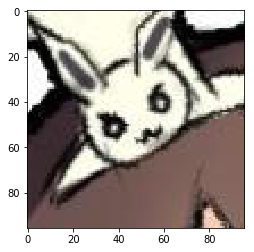

(96, 96, 3)


In [4]:
img = imageio.imread(img_list[0])
plt.imshow(img)
plt.show()

print(img.shape)

In [5]:
class AnimeDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, img_list, transforms=None):
        super().__init__()
        self.transforms = transforms
        
        self.x_filename_list = img_list
        self.len = len(self.x_filename_list) # Size of data
        
    def __getitem__(self, index):
#         x_data = imageio.imread(self.x_filename_list[index])
        x_data = Image.open(self.x_filename_list[index])
    
        if len(np.array(x_data).shape) == 2:
            x_data = np.stack((x_data,)*3, axis=-1)
            x_data = Image.fromarray(x_data)
            
        if np.array(x_data).shape[2] == 4:
            x_data = np.array(x_data)[:, :, :3]
            x_data = Image.fromarray(x_data)
        
        return self.transforms(x_data)
        
    def __len__(self):
        return self.len

In [15]:
# class Generator(nn.Module):
#     def __init__(self, ngpu, nz, nc , ngf, n_extra_layers_g):
#         super(_netG_1, self).__init__()
#         self.ngpu = ngpu
#         #self.nz = nz
#         #self.nc = nc
#         #self.ngf = ngf
#         main = nn.Sequential(
#             # input is Z, going into a convolution
#             # state size. nz x 1 x 1
#             nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ngf) x 32 x 32
#         )

#         # Extra layers
#         for t in range(n_extra_layers_g):
#             main.add_module('extra-layers-{0}.{1}.conv'.format(t, ngf),
#                             nn.Conv2d(ngf, ngf, 3, 1, 1, bias=False))
#             main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, ngf),
#                             nn.BatchNorm2d(ngf))
#             main.add_module('extra-layers-{0}.{1}.relu'.format(t, ngf),
#                             nn.LeakyReLU(0.2, inplace=True))

#         main.add_module('final_layer.deconv', 
#         	             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)) # 5,3,1 for 96x96
#         main.add_module('final_layer.tanh', 
#         	             nn.Tanh())
#             # state size. (nc) x 96 x 96

#         self.main = main


#     def forward(self, input):
#         gpu_ids = None
#         if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
#             gpu_ids = range(self.ngpu)
#         return nn.parallel.data_parallel(self.main, input, gpu_ids), 0

# class Discriminator(nn.Module):
#     def __init__(self, ngpu, nz, nc, ndf,  n_extra_layers_d):
#         super(_netD_1, self).__init__()
#         self.ngpu = ngpu
#         main = nn.Sequential(
#             # input is (nc) x 96 x 96
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # 5,3,1 for 96x96
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#         )

#         # Extra layers
#         for t in range(n_extra_layers_d):
#             main.add_module('extra-layers-{0}.{1}.conv'.format(t, ndf * 8),
#                             nn.Conv2d(ndf * 8, ndf * 8, 3, 1, 1, bias=False))
#             main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, ndf * 8),
#                             nn.BatchNorm2d(ndf * 8))
#             main.add_module('extra-layers-{0}.{1}.relu'.format(t, ndf * 8),
#                             nn.LeakyReLU(0.2, inplace=True))


#         main.add_module('final_layers.conv', nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False))
#         main.add_module('final_layers.sigmoid', nn.Sigmoid())
#         # state size. 1 x 1 x 1
#         self.main = main

#     def forward(self, input):
#         gpu_ids = None
#         if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
#             gpu_ids = range(self.ngpu)
#         output = nn.parallel.data_parallel(self.main, input, gpu_ids)
#         return output.view(-1, 1)
    
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, 1024, kernel_size=4)
        self.bn1 = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 3, kernel_size=5, stride=3, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = self.bn1(x)
        x = F.relu(self.deconv2(x))
        x = self.bn2(x)
        x = F.relu(self.deconv3(x))
        x = self.bn3(x)
        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.deconv5(x)
        x = self.sigmoid(x)
        
        return x
        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
#         print(x.shape)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        
        return x.view(-1)

In [8]:
batch_size = 256

transformer = transforms.Compose([transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor()])
anime_dataset = AnimeDataset(img_list, transforms=transformer)
anime_loader = torch.utils.data.DataLoader(anime_dataset, batch_size=batch_size)

mean_list = []
# counter = 0

for data in tqdm(anime_loader):
    x = data
    x = x.view(x.size(0), x.size(1), -1)
    mean_list.append(x.mean(2).mean(0))
    # counter += 1

    # if counter >= 5:
    #     break

mean = torch.stack(mean_list).mean(dim=0)
se = torch.stack(mean_list).std(dim=0)
std = se * torch.sqrt(torch.tensor(float(batch_size)))

print("=============================")
print("Batch size: {}".format(batch_size))
print("Mean: {}".format(mean))
print("SE: {}".format(se))
print("STD: {}".format(std))

100%|██████████| 1010/1010 [02:03<00:00,  8.19it/s]

Batch size: 256
Mean: tensor([0.7222, 0.6402, 0.6237])
SE: tensor([0.0336, 0.0328, 0.0352])
STD: tensor([0.5371, 0.5246, 0.5638])


In [9]:
kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else {}

gan_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.7223, 0.6403, 0.6237), (0.5371, 0.5246, 0.5638))
                                    ])

anime_dataset = AnimeDataset(img_list, transforms=gan_transforms)
img_loader = torch.utils.data.DataLoader(anime_dataset, batch_size=batch_size, **kwargs)

# torch.cuda.set_device(8)

In [12]:
import math


def train(generator, discriminator, epochs, batch_size):
    grid_size = int(math.sqrt(batch_size))
    criterion = nn.BCELoss()
    
    if torch.cuda.is_available():
        generator = generator.cuda()
        discriminator = discriminator.cuda()
    
    optimizer_d = Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    optimizer_g = Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    fake_criterion = lambda x: -(1 - torch.log(x)).mean()
    real_criterion = lambda x: -(torch.log(x)).mean()
#     d_criterion = nn.BCELoss()
    
    g_loss_list = []
    d_loss_list = []
    
    epoch_counter = 1
    
    z_test = torch.randn(batch_size, 100, 1, 1)
        
        if torch.cuda.is_available():
            z_test = z_test.cuda()        
            
    while True:
#     for i, epoch in enumerate(range(epochs), 1):
        for j, real_img in enumerate(img_loader, 1):            
            b_size = real_img.shape[0]
            z = torch.randn(b_size, 100, 1, 1)
            true_label = Variable(torch.ones(b_size))
            fake_label = Variable(torch.zeros(b_size))
            
            if torch.cuda.is_available():
                real_img = real_img.cuda()
                z = z.cuda()
                true_label, fake_label = true_label.cuda(), fake_label.cuda()
              
            # D: Backprop real loss
            real_pred = discriminator(real_img)
#             d_real_loss = real_criterion(real_pred)
            d_real_loss = criterion(real_pred, true_label)
            d_real_loss.backward()
            
            # D: Backprop fake loss
            fake_img = generator(z).detach()
            fake_pred = discriminator(fake_img)
#             d_fake_loss = fake_criterion(fake_pred)
            d_fake_loss = criterion(fake_pred, fake_label)
            d_fake_loss.backward()
            optimizer_d.step()
    
            if j % 5 == 0:
                # G: Backprop fake loss
                fake_img = generator(z)
                fake_pred = discriminator(fake_img)
    #             g_fake_loss = real_criterion(fake_pred)
                g_fake_loss = criterion(fake_pred, true_label)
                g_fake_loss.backward()
                optimizer_g.step()

                optimizer_d.zero_grad()
                optimizer_g.zero_grad()

                g_loss_list.append(g_fake_loss.detach())
                d_loss_list.append(d_real_loss.detach() + d_fake_loss.detach())
            
            if j % 100 == 0:
#                 print("Epoch: {}, Iter: {}, GLoss: {}, DLoss: {}".format(i, j, g_loss, d_loss))
                print("Epoch: {}, Iter: {}, GLoss: {}, DLoss: {}".format(epoch_counter, j, g_fake_loss, d_real_loss.detach() + d_fake_loss.detach()))
              
        img_torch = generator(z_test)
        imgs = img_torch.cpu().detach().numpy()
        imgs = (((imgs + 1) * 255) / 2).astype(np.uint8)

        img_wall = np.zeros((grid_size * 96, grid_size * 96, 3)).astype(np.uint8)

        j = 0

        for i, image in enumerate(imgs):
            img = np.rollaxis(image, 0, 3)

            x_start, x_end = (i % grid_size) * 96, (i % grid_size + 1) * 96
            y_start, y_end = j * 96, (j + 1) * 96

            img_wall[x_start:x_end, y_start:y_end, :] = img

            if (i + 1) % grid_size == 0:
                j += 1

        plt.figure(figsize=(grid_size, grid_size))
        plt.imshow(img_wall)
        plt.show()
        
        plt.plot(range(len(g_loss_list)), g_loss_list, label='G Loss')
        plt.plot(range(len(d_loss_list)), d_loss_list, label='D Loss')
        plt.legend()
        plt.show()
        
        epoch_counter += 1

In [13]:
def random_weight_init(model):
    for layer in model.modules():
        classname = layer.__class__.__name__
        if classname.find('Conv') != -1:
            layer.weight.data = nn.init.kaiming_normal(layer.weight.data)
        elif classname.find('BatchNorm') != -1:
            layer.weight.data.normal_(1.0, 0.02)
            layer.bias.data.fill_(0)
        elif classname.find('Linear') != -1:
            layer.weight.data = nn.init.kaiming_normal(layer.weight.data)

/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


Let's use 2 GPUs!
Epoch: 1, Iter: 100, GLoss: 14.69725227355957, DLoss: 0.00023048068396747112
Epoch: 1, Iter: 200, GLoss: 24.854829788208008, DLoss: 1.0992692295985762e-05
Epoch: 1, Iter: 300, GLoss: 15.788495063781738, DLoss: 1.2736823919112794e-05
Epoch: 1, Iter: 400, GLoss: 68.72174072265625, DLoss: 2.4671640858286992e-05
Epoch: 1, Iter: 500, GLoss: 69.11555480957031, DLoss: 1.3038536472720352e-08
Epoch: 1, Iter: 600, GLoss: 69.2674789428711, DLoss: 5.560264639825618e-07
Epoch: 1, Iter: 700, GLoss: 69.25643157958984, DLoss: 5.489977866091067e-06
Epoch: 1, Iter: 800, GLoss: 69.75108337402344, DLoss: 6.631165092585434e-07
Epoch: 1, Iter: 900, GLoss: 69.93997192382812, DLoss: 1.3504187101887055e-08
Epoch: 1, Iter: 1000, GLoss: 70.17984771728516, DLoss: 2.686917355276819e-07


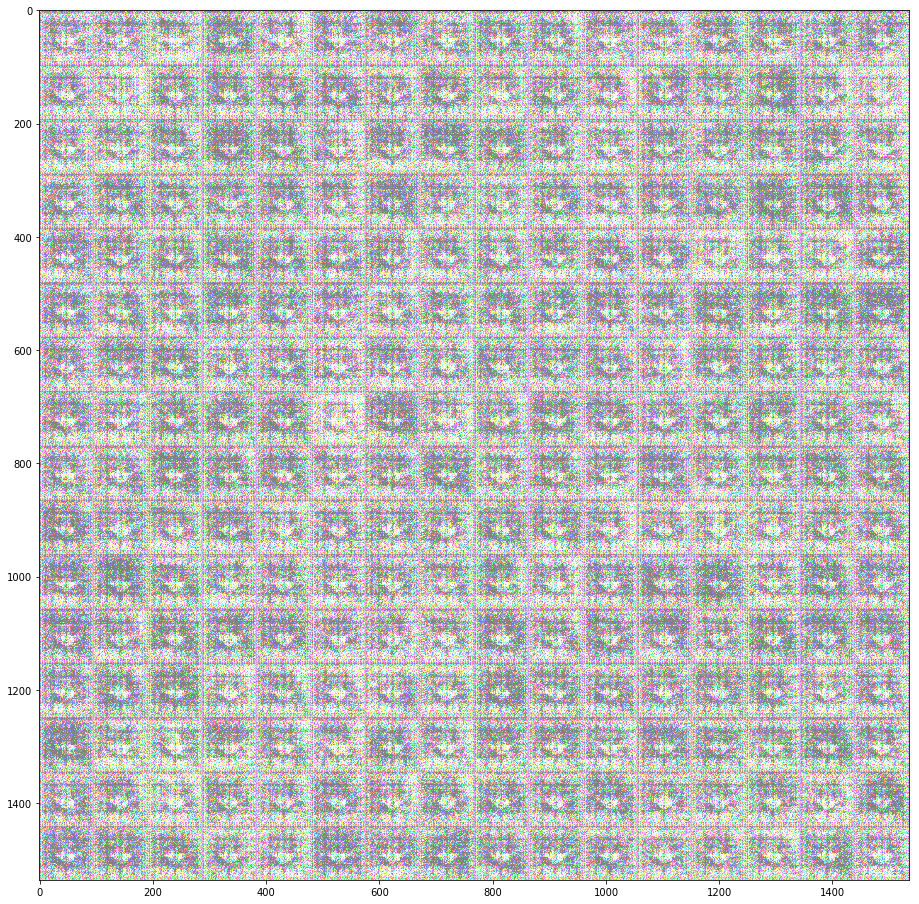

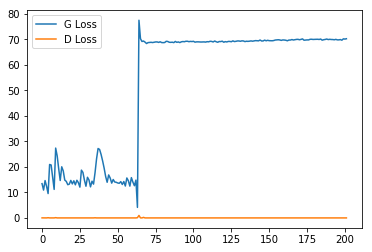

Epoch: 2, Iter: 100, GLoss: 69.71925354003906, DLoss: 1.2107202351785418e-08
Epoch: 2, Iter: 200, GLoss: 69.64210510253906, DLoss: 5.024600682190794e-07
Epoch: 2, Iter: 300, GLoss: 70.36466979980469, DLoss: 7.916243660588407e-09
Epoch: 2, Iter: 400, GLoss: 70.3780288696289, DLoss: 3.864993658453386e-08
Epoch: 2, Iter: 500, GLoss: 70.5611801147461, DLoss: 0.0
Epoch: 2, Iter: 600, GLoss: 70.55601501464844, DLoss: 6.9849206418837184e-09
Epoch: 2, Iter: 700, GLoss: 70.5380859375, DLoss: 2.6729148316917417e-07
Epoch: 2, Iter: 800, GLoss: 70.73008728027344, DLoss: 4.950130687575438e-07
Epoch: 2, Iter: 900, GLoss: 70.46192932128906, DLoss: 4.656614205345022e-09
Epoch: 2, Iter: 1000, GLoss: 70.55734252929688, DLoss: 2.328309989252375e-08


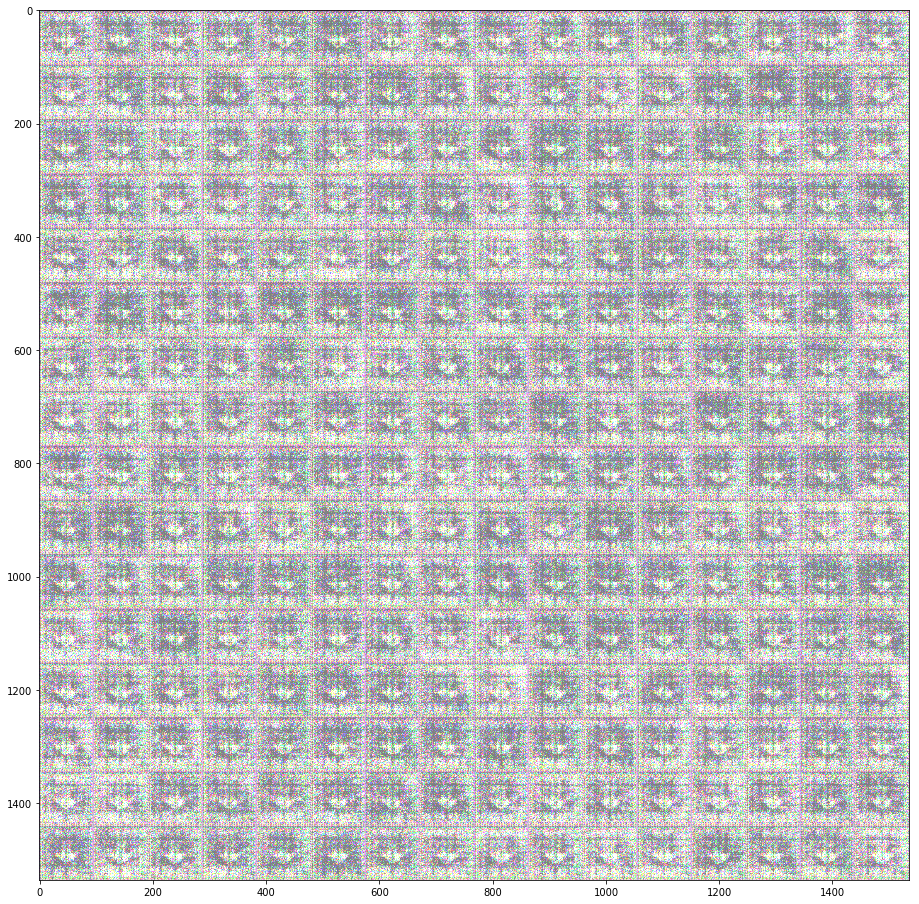

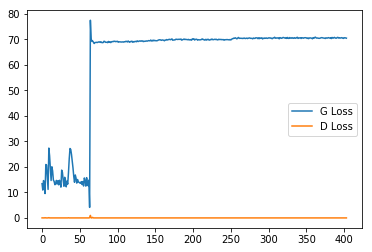

Epoch: 3, Iter: 100, GLoss: 70.15079498291016, DLoss: 2.7939681679356454e-09
Epoch: 3, Iter: 200, GLoss: 70.41630554199219, DLoss: 2.826591583016125e-07
Epoch: 3, Iter: 300, GLoss: 70.39739227294922, DLoss: 1.3969840839678227e-09
Epoch: 3, Iter: 400, GLoss: 70.60114288330078, DLoss: 1.4901166522918174e-08
Epoch: 3, Iter: 500, GLoss: 70.68852233886719, DLoss: 0.0
Epoch: 3, Iter: 600, GLoss: 70.7018814086914, DLoss: 1.024455720255446e-08
Epoch: 3, Iter: 700, GLoss: 70.46440887451172, DLoss: 1.9790731187185884e-07


Process Process-24:
Process Process-21:
Process Process-17:
Process Process-18:
Process Process-19:
Process Process-22:
Process Process-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-23:
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/calvinku/anaconda

  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/calvinku/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  Fil

KeyboardInterrupt: 

In [16]:
generator = Generator()
discriminator = Discriminator()

random_weight_init(generator), random_weight_init(discriminator)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

train(generator, discriminator, 100, batch_size)